In [1]:
# This notebook uses the RAGAS evaluation library to evaluate several metrics for a RAG pipeline
# I use the Google Gemini API (free tier, local API key), but RAGAS is compatible with several LLMs

# Google Gemini: https://ai.google.dev/gemini-api/docs/models/gemini
# RAGAS: https://docs.ragas.io/en/stable/
# I used RAGAS v0.1.15 (mine was dev version from Github, but 0.1.15 from PyPI should work fine). 

# Note: I had to edit underlying RAGAS library (cloned locally, edited files, then pip -e installed locally) for this issue re: temperature with Gemini:
# https://github.com/explodinggradients/ragas/pull/657/files
# https://github.com/explodinggradients/ragas/issues/678
# Edits simply remove the temperature variable from the relevant source files; see notes.txt for more specific info

# RAGAS had a large redesign from version 0.1 to 0.2 : https://docs.ragas.io/en/stable/howtos/migrations/migrate_from_v01_to_v02/
# - Note that on RAGAS version 0.2.6, the temperature edits did not make RAGAS compatible with Gemini.
# - There are open Github issues about Gemini's compatibility for RAGAS version 2+; more time and edits would be needed.

In [2]:
# RAGAS metrics guide: https://docs.ragas.io/en/latest/concepts/metrics/index.html#ragas-metrics

# Faithfulness - Measures the factual consistency of the answer to the context based on the question.
# Context_precision - Measures how relevant the retrieved context is to the question, conveying the quality of the retrieval pipeline.
# Answer_relevancy - Measures how relevant the answer is to the question.
# Context_recall - Measures the retriever’s ability to retrieve all necessary information required to answer the question.

# Faithfulness with HHEM - Similar to Faithfulness but uses a HuggingFace model (Vectara's HHEM 2.1 classifier) to detect hallucinations
# https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html#faithfullness-with-hhem-2-1-model
# https://huggingface.co/vectara/hallucination_evaluation_model

# RAGAS has other metrics as well : https://docs.ragas.io/en/latest/concepts/metrics/index.html

In [1]:
# Set do not track variable for RAGAS
# More info: https://github.com/explodinggradients/ragas/issues/49
import os
os.environ["RAGAS_DO_NOT_TRACK"] = "True"

In [2]:
import logging
import sys
import textwrap
import ast
import time
import pandas as pd
from IPython.display import display
from IPython.display import Markdown

# Replace these two Google Gemini imports with imports for your LLM
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

from langchain_community.document_loaders import DirectoryLoader
from llama_index.core import Document, VectorStoreIndex, Settings, StorageContext, load_index_from_storage
from llama_index.vector_stores.faiss import FaissVectorStore
import faiss

import ragas
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from ragas.run_config import RunConfig
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from ragas import evaluate
from datasets import Dataset

In [3]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [4]:
# Double check the RAGAS do not track setting
ragas._analytics.do_not_track()

True

In [5]:
# Set up local API key
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [ ]:
# Establish RAG pipeline with Gemini

In [7]:
# # Create a Faiss vector store for RAG
# # If you already have an index created, skip a few coding cells to the LLM / embeddings setup

# # Example of creating a small vector store
# # Using 4 State of the Union speeches, all text from whitehouse.gov briefing room speeches posted online, edited to include a title with the date of the speech
# # Example from 2024:
# # https://www.whitehouse.gov/briefing-room/speeches-remarks/2024/03/07/remarks-of-president-joe-biden-state-of-the-union-address-as-prepared-for-delivery-2/

# # load and parse files
# sotu = []
# newfiles = ["./Speeches/titleedits/state_of_the_union_042921.txt", "./Speeches/titleedits/state_of_the_union_030122.txt", "./Speeches/titleedits/state_of_the_union_020723.txt", "./Speeches/titleedits/state_of_the_union_030724.txt"]
# for i in newfiles:
#     with open(i) as file:
#         for line in file:
#             nl = line.rstrip()
#             if nl != '':
#                 sotu.append(nl)

# # Convert into Document format for Faiss
# documents = [Document(text=line) for line in sotu]

In [9]:
# # Example of a loaded Document line
# documents[-1]

Document(id_='235d1f3b-a216-412c-8459-51d27c73c8d0', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='May God protect our troops.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')

In [ ]:
# # Set up the Faiss index
# d = 768 # dimensions of the input vector of the embedding model that we're going to use; in this case, the google embedding model
# faiss_index = faiss.IndexFlatL2(d)
# print(faiss_index.is_trained) # double check that the training worked

In [6]:
# Set up the llm, embeddings, and Settings for Faiss 
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash") # Replace with your LLM
doc_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004") # Replace with your embeddings model
Settings.embed_model = doc_embeddings # used for LlamaIndex FaissVectorStore
Settings.llm = llm # used for LlamaIndex FaissVectorStore

In [7]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [8]:
# # Uncomment for when you need to re-embed and vectorize documents

# vector_store = FaissVectorStore(faiss_index=faiss_index)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)
# index = VectorStoreIndex.from_documents(
#     documents, storage_context=storage_context, show_progress=True
# )

# # Save index to disk
# index.storage_context.persist()

# # Save/remember index id for loading next time
# index.index_id

In [8]:
# After you have a saved index, load that index for RAG answer generation:

# load index from disk
vector_store = FaissVectorStore.from_persist_dir("./storage")
storage_context = StorageContext.from_defaults(
    vector_store=vector_store, persist_dir="./storage"
)
# My local index id '3d3c99c5-aa1c-42d7-a9ce-c4bb12fbc6d5' uses the 4 speeches including a title that includes the date it was given
# My local index id '95634851-570e-454e-983f-6634eeb72aee' contains 3200 documents from the rag_mini_wikipedia dataset
index = load_index_from_storage(storage_context=storage_context, index_id='95634851-570e-454e-983f-6634eeb72aee')

INFO:root:Loading llama_index.vector_stores.faiss.base from ./storage/default__vector_store.json.
Loading llama_index.vector_stores.faiss.base from ./storage/default__vector_store.json.
INFO:llama_index.core.indices.loading:Loading indices with ids: ['95634851-570e-454e-983f-6634eeb72aee']
Loading indices with ids: ['95634851-570e-454e-983f-6634eeb72aee']


In [11]:
# # Optional- if you'd like to query your index
# # Set up query and chat engines with the index
# query_engine = index.as_query_engine(similarity_top_k=10)
# chat_engine = index.as_chat_engine(similarity_top_k=10, chat_mode='context')

In [ ]:
# # Example query and response with Gemini and query_engine
# query = "What has the President done related to healthcare?"
# response = query_engine.query(query) 
# print(response.response)

In [ ]:
# # Get ranked scores for top k RAG source nodes
# for node in response.source_nodes:
#     print(f"{node.get_score()} -> {node.text}")

In [ ]:
# # Example of using the chat engine with our index
# query = "You are an expert speech analyst and specialize in analyzing Presidential State of the Union speeches. Could you please analyze the speeches and generate 2 questions and answers from each speech, providing the document filename of each speech that relates to each question?"
# response = chat_engine.chat(query) 
# print(response.response)

In [22]:
# # View chat history
# chat_engine.chat_history

In [20]:
# Code for RAGAS evaluation library to work with Gemini and our local RAG setup

In [21]:
# Example of generating synthetic dataset with RAGAS

# In a synthetic dataset, columns generated are 'question', 'contexts', 'ground_truth', 'evolution_type', 'metadata', and 'episode_done'
# Ground truth is supposed to be the 'human' level answer vs the RAG answer

# Notes: 
# - We have to generate the answer separately with our RAG, which then generates new context used.
# - I use the context that was used to generate the answer for the metrics calculation, while still saving the old contexts column.
# - The best thing to do would be to generate the answer when creating the synthetic test dataset, but this is not available in RAGAS.
# - From a Github issue: Since you use the same LLM to generate your synthetic dataset ground_truth and your answer, 
# - it is possible the results of the RAG evaluation might be biased. This has not been studied.

In [10]:
# Load documents for use in generating synthetic dataset with RAGAS
loader = DirectoryLoader("./Speeches/titleedits") # Loads all documents in the directory; there are parameters for ignoring or matching certain files
documents = loader.load()

In [11]:
# Need to add 'filename' metadata for RAGAS to process documents
for document in documents:
    document.metadata['filename'] = document.metadata['source']

In [38]:
# Synthetic testset generator with Gemini models
generator_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", timeout=240) # Other notable parameters: temperature=0.7, transport="rest"
critic_llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", timeout=240) 
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", request_options={"timeout": 240}) 

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

In [9]:
# Increase the timeout settings with RAGAS's RunConfig class

# Note: For Gemini, the RAGAS internal RunConfig settings do a decent job at limiting the 429 resource exhausted warnings
# (max_workers=1 still can send more requests to Gemini than the 15 requests per minute it allows)
# Still very difficult to have the testset generation run successfully with Gemini free tier
# I also tried the ratelimit and backoff libraries in Python, but I still got so many 429 warnings that the generation failed
# Sometimes even the 1 max worker will not finish, but it will finish occasionally

run_config = RunConfig(timeout=240, max_retries=20, max_wait=240, max_workers=1)

In [21]:
# Generate the synthetic dataset/testset
def generate_testset_rate(docs):
    """
    Calls the LLM and embeddings model to generate the synthetic dataset with rate limit run_config
    Can change the distribution of simple, reasoning, and multi-context questions generated
    """
    testset = generator.generate_with_langchain_docs(documents=documents, # Uses LangChain's DirectoryLoader source documents
                                                     test_size=50, # Number of test samples to generate
                                                     distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25}, # Different types of queries to generate
                                                     is_async=False,
                                                     raise_exceptions=True, 
                                                     run_config=run_config)
    return testset

In [ ]:
testset = generate_testset_rate(documents=documents, run_config=run_config) # ToDo: Test run_config here, may not have passed it before
testset_pd = testset.to_pandas()

In [34]:
# # Save generated testset to csv 
# testset_pd.to_csv('datasets/testset_flash_pro15.csv', index=False)

In [23]:
# # Now generate answers for the testset, as answers are not automatically generated at creation

# testset_pd = pd.read_csv("datasets/testset_flash_pro15.csv", index_col = None)

# Note: When saving, the 'contexts' column is saved as a string but needs to be a list
# If you are importing testset_pd from a csv file, use the below code to change the column to a list

# testset_pd['contexts'] = testset_pd['contexts'].apply(ast.literal_eval)

In [ ]:
# Generate answers using our query engine & Faiss vector database
# Alternatively can use the chat_engine if memory between queries is needed (i.e., queries reference previous queries)
query_engine = index.as_query_engine(similarity_top_k=10)
answers = [query_engine.query(q) for q in testset_pd['question']]

In [25]:
# Parse out new 'answer' and 'contexts' columns
answers_new = []
context_new = []
for i in answers:
    answers_new.append(i.response)
    context_new.append([c.node.get_content() for c in i.source_nodes])

testset_pd = testset_pd.rename(columns={"contexts":"contexts_gt"}) # Keeping old contexts that were used for testset/query generation (gt = ground truth)
testset_pd['contexts'] = context_new
testset_pd['answer'] = answers_new

# Save complete synthetically created dataset/testset
# testset_pd.to_csv('datasets/ragas_full_testset_flash_pro15.csv', index=False)

In [ ]:
# Evaluate a dataset with RAGAS

In [9]:
# Read in dataset for evaluation
testset_pd = pd.read_csv("datasets/rag_mini_wikipedia_complete_chat.csv", index_col = None) 

# RAGAS expects the following columns (rename in dataset as needed) : "question", "answer", "ground_truth", "source_file", "contexts"
#testset_pd = testset_pd.rename(columns={"Query": "question", "Answer": "answer", "Expected_Output": "ground_truth", "Contexts": "orig_contexts", "Source_File":"source_file", "Document": "contexts"})

# Note: When saving a synthetic dataset, the 'contexts' column is saved as a string but needs to be a list for evaluation
# If you are importing testset_pd from a csv file that is a synthetic dataset, use the below code to change the column to a list
# This may apply to other datasets as well
testset_pd['contexts'] = testset_pd['contexts'].apply(ast.literal_eval)

In [10]:
# At least for RAGAS v0.1.15, we need to convert the pandas testset into Dataset format for the evaluate function to work
# Note: I am also dropping the original contexts column here, as well as any extra columns
testset_ds = Dataset.from_pandas(testset_pd.drop("id", axis=1))

In [11]:
testset_ds

Dataset({
    features: ['question', 'ground_truth', 'contexts', 'answer'],
    num_rows: 918
})

In [12]:
# Note: I'm using the normal LLM, not the RAG context-loaded query engine
# There is code at the bottom of the notebook for using the query engine, but it appears to just use the query engine to develop
# new answers and contexts and then to use the non-RAG LLM for the metrics evaluation
# That code also appears to be broken from RAGAS right now, so I was forced to use the regular Gemini LLM anyway

# Note: The RAGAS evaluate function (below) may re-run the query and give new answers and contexts
# See this issue: https://github.com/explodinggradients/ragas/issues/1211
# In testing, the results still output the same answers and contexts as I started with, so I'm not concerned by this

ragas_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", timeout=600) 
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [13]:
# Increase the timeout settings
run_config = RunConfig(timeout=300, max_wait=3000, max_workers=1, max_retries=10)

In [ ]:
# Two coding options for running evaluate:
# 1) Bulk run with the evaluate function, as intended. 
# Unfortunately rate-limiting does not work well with this, 
# and 2/3 of my 800 example dataset received NaN results because of rate limiting issues.
# Ex: Evaluating 1 example for 1 metric resulted in 10 API calls.

# 2) Run the evaluation in small batches
# This allowed me to finish the evaluation of the entire dataset without rate limiting errors.

# Bulk evaluation of the dataset
evalresult = evaluate(
    metrics = [
        context_precision
        faithfulness,
        answer_relevancy,
        context_recall
    ],
    dataset = testset_ds,
    llm = ragas_llm,
    embeddings=embeddings,
    run_config=run_config
)

# Optional parameter: in_ci: bool, Whether the evaluation is running in CI or not. 
# If set to True then some metrics will be run to increase the reproducability of the evaluations. 
# This will increase the runtime and cost of evaluations. Default is False.
# In practice, setting in_ci = True resulted in a lot of timeouts / no score calculated / NaN

In [61]:
# Example result:
# {'context_precision': 0.4676, 'faithfulness': 1.0000, 'answer_relevancy': 0.6515, 'context_recall': 0.8000}
evalresult

{'context_precision': 0.5979, 'faithfulness': 1.0000, 'answer_relevancy': 0.6533, 'context_recall': 0.8000}

In [34]:
# evalresult.to_pandas() # Returns the dataset with scores for each example

In [14]:
# Setup for smaller batches
testset_results = pd.DataFrame()

In [22]:
# Iterate through dataset for smaller batches to be evaluated
for i in range(908,918):  # Choose the batch size in the range selection # last 297 didn't execute # If I missed one it was in 390-393 #895 & 896 didn't execute; didn't save
    tempdataset = testset_ds.select(range(i, i+1)) # Match the batch size in the dataset selection
    print(i)
    evalresult = evaluate(
        metrics = [
            context_precision
            #faithfulness,
            #answer_relevancy,
            #context_recall
        ],
        dataset = tempdataset,
        llm = ragas_llm,
        embeddings=embeddings,
        run_config=run_config
    )
    testset_results = pd.concat([testset_results, evalresult.to_pandas()])
    time.sleep(60) # RAGAS generates ~10 API calls per example. Gemini free-tier limit is 15RPM, so we need to wait a minute between calls for the limit to reset.

908


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

909


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

910


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

911


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

912


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

913


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

914


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

915


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

916


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

917


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
testset_results.isnull().sum()
#testset_results #testset_results.iloc[0:147]

question             0
ground_truth         0
contexts             0
answer               0
context_precision    0
dtype: int64

In [28]:
testset_results

,question,ground_truth,contexts,answer,context_precision
0,What caused Wilson to ask Congress to declare ...,German began unrestricted submarine warfare,[When Germany resumed unrestricted submarine w...,Several factors led Woodrow Wilson to ask Cong...,0.791667
0,What was more damaging than moving students in...,His confrontation with Andrew Fleming West,[The shortage of places in post-secondary educ...,In the context of Woodrow Wilson's presidency ...,0.200000
0,Was Wilson a member of the Phi Kappa Psi frate...,yes,[* Wilson was a member of the Phi Kappa Psi fr...,"Yes, Woodrow Wilson was a member of the Phi Ka...",1.000000
0,Was Wilson an automobile enthusiast?,yes,"[Wilson's Pierce Arrow, which resides in his h...",While not an *avid* enthusiast in the sense of...,0.700000
0,Did Wilson's father own slaves?,yes,"[Thomas Woodrow Wilson was born in Staunton, V...","Yes, Woodrow Wilson's father, Joseph Ruggles W...",1.000000
0,Where is Wilson buried?,He was buried in Washington National Cathedral,[* Wilson is the only U.S. President buried in...,Woodrow Wilson is buried in Washington Nationa...,0.416667
0,Where did Wilson attend law school?,Wilson attended law school at University of Vi...,[* Wilson was a member of the Phi Kappa Psi fr...,Woodrow Wilson attended the University of Virg...,0.416667
0,Where was Woodrow Wilson born?,"Woodrow Wilson was born in Staunton, Virginia","[Thomas Woodrow Wilson (December 28, 1856âFe...","Woodrow Wilson was born in Staunton, Virginia.\n",0.416667
0,Did Wilson support desegregation?,no,[Wilson allowed many of his cabinet officials ...,"No, Woodrow Wilson did not support desegregati...",0.634921
0,Did Wilson support the committee system?,no,"[In addition to their undemocratic nature, Wil...","No, Woodrow Wilson was a strong critic of the ...",0.611111


In [30]:
testset_ds.select([917])['question']

['What happened in 1917?']

In [31]:
# Recommend checking contexts column to be sure context nodes are separated from each other after saving
testset_results.to_csv("results/results_ragas_rag_mini_wiki_complete_chat_896_918.csv", index=False)

In [30]:
#checking = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_150_297.csv", index_col=None)

In [31]:
#checking.isnull().sum()

question             0
ground_truth         0
contexts             0
answer               0
context_precision    0
dtype: int64

In [ ]:
# Note: received warning for the answer where there was no response from the llm, definitely reduced faithfulness score

# Results:
# Using contexts generated when produced answers from LLM:
# new testset_answer_newcontext_flash_pro15.csv result, with contexts_gt (aka contexts generated with ground truth generation) column removed
# {'context_precision': 0.4171, 'faithfulness': 0.9167, 'answer_relevancy': 0.6509, 'context_recall': 0.8000}
# reran
# {'context_precision': 0.4676, 'faithfulness': 1.0000, 'answer_relevancy': 0.6515, 'context_recall': 0.8000}
# reran
# {'context_precision': 0.5979, 'faithfulness': 1.0000, 'answer_relevancy': 0.6533, 'context_recall': 0.8000}

# Compared to using contexts generated for ground truth (probably not correct):
# new testset_answer_newcontext_flash_pro15.csv result, using old contexts
# {'context_precision': 0.7500, 'faithfulness': 0.7392, 'answer_relevancy': 0.6041, 'context_recall': 1.0000}
# reran:
# {'context_precision': 0.8500, 'faithfulness': 0.7123, 'answer_relevancy': 0.5934, 'context_recall': 1.0000}
# reran:
# {'context_precision': 0.7500, 'faithfulness': 0.6556, 'answer_relevancy': 0.5638, 'context_recall': 1.0000}

In [ ]:
# Evaluation results on metrics:

# RAGAS metrics guide: https://docs.ragas.io/en/latest/concepts/metrics/index.html#ragas-metrics
# I don't have example ranges to compare anything to, so below is my best guess.

# Faithfulness - Measures the factual consistency of the answer to the context based on the question.
# 0.9167 - 1.0000 indicates that the LLM is staying true to the facts provided in the context for answering the question.
# There is another Faithfulness metric: from ragas.metrics import FaithulnesswithHHEM
# This uses a huggingface model to help detect hallucination : https://huggingface.co/vectara/hallucination_evaluation_model
# See below for code : {'faithfulness_with_hhem': 0.6319} 
# This doesn't really agree with the RAGAS faithfulness score... may need to dive in further another time.
# Context_precision - Measures how relevant the retrieved context is to the question, conveying the quality of the retrieval pipeline.
# At 0.4171 - 0.5979, suggests that the context isn't particularly relevant to the question.
# Answer_relevancy - Measures how relevant the answer is to the question.
# 0.6509 - 0.6533 seems moderately low, just going off of the number.
# Context_recall - Measures the retriever’s ability to retrieve all necessary information required to answer the question.
# 0.8 indicates that the llm context is decently good and can typically answer the question or most of it. 

In [105]:
# Test run, just compare to using contexts_gt column instead of the newer context generated with the answer
testset_ds_oldcontext = Dataset.from_pandas(testset_pd.drop("contexts", axis=1).rename(columns={'contexts_old':'contexts'}))

In [ ]:
evalresult_old2 = evaluate(
    testset_ds_oldcontext,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
    llm = ragas_llm,
    embeddings=embeddings, 
    run_config=run_config
)

In [ ]:
# new testset_answer_newcontext_flash_pro15.csv result, using old contexts
# {'context_precision': 0.7500, 'faithfulness': 0.7392, 'answer_relevancy': 0.6041, 'context_recall': 1.0000}
# reran:
# {'context_precision': 0.8500, 'faithfulness': 0.7123, 'answer_relevancy': 0.5934, 'context_recall': 1.0000}
# reran:
# {'context_precision': 0.7500, 'faithfulness': 0.6556, 'answer_relevancy': 0.5638, 'context_recall': 1.0000}
evalresult_old2

In [ ]:
# RAGAS also has an additional Faithfulness with HHEM metric (yes- it is misspelled in their documentation) 
# that uses a HuggingFace model to detect hallucinations
# Note: There's a message on HuggingFace about the token indices sequence length error being normal and an artifact; thus, ignoring the below error
# https://huggingface.co/vectara/hallucination_evaluation_model
from ragas.metrics import FaithulnesswithHHEM
faithfulness_with_hhem = FaithulnesswithHHEM()
result_faithfulness_hhem = evaluate(
    testset_ds,
    metrics=[faithfulness_with_hhem],
    llm = ragas_llm,
    embeddings=embeddings, 
    run_config=run_config
)

In [158]:
# with context from answer generation:
# {'faithfulness_with_hhem': 0.6319}
# testing: with context from ground truth/synthetic testset generation
# {'faithfulness_with_hhem': 0.5241}
# this seems to agree with the RAGAS faithfulness score in that answers seem to be partially made up.
result_faithfulness_hhem

{'faithfulness_with_hhem': 0.6319}

In [84]:
# Extra non-working code:

In [85]:
# Code to use the query_engine in the evaluation 
# Modeled after this tutorial: https://docs.ragas.io/en/latest/howtos/applications/compare_llms.html

# Does not currently work: for some metrics, it is not finding the 'ground_truth' column in the dataset
# For other metrics, appears to run but returns the below errors and returns 'nan' for results

In [64]:
# start of testing to try and get rag query engine for evaluate
def generate_responses(query_engine, test_questions, test_answers):
  responses = [query_engine.query(q) for q in test_questions]

  answers = []
  contexts = []
  for r in responses:
    answers.append(r.response)
    contexts.append([c.node.get_content() for c in r.source_nodes])
  dataset_dict = {
        "question": test_questions,
        "answer": answers,
        "contexts": contexts,
  }
  if test_answers is not None:
    dataset_dict["ground_truth"] = test_answers
  ds = Dataset.from_dict(dataset_dict)
  return ds

test_questions = testset_pd['question'].values.tolist()
test_answers = [[item] for item in testset_pd['answer'].values.tolist()]

result_ds = generate_responses(query_engine, test_questions, test_answers)

In [ ]:
# # Set up query and chat engines with the index
# query_engine = index.as_query_engine(similarity_top_k=10)
# chat_engine = index.as_chat_engine(similarity_top_k=10, chat_mode='context')

In [ ]:
# Note: This evaluate function that uses the query_engine does not return results (nan for all metrics)
# In reviewing the code for the evaluate function below from ragas, it uses the query_engine to develop new answers and contexts
# before ultimately calling the normal ragas evaluate function that uses the non-RAG llm to evaluate the metrics
# Thus, I don't think this code does what I'm looking for;
# That is, it doesn't evaluate a dataset for a given metric by using the query_engine as opposed to the non-RAG llm

# Errors (below are repeated many times):
# WARNING:ragas.llms.base:n values greater than 1 not support for LlamaIndex LLMs
# n values greater than 1 not support for LlamaIndex LLMs
# INFO:ragas.llms.base:callbacks not supported for LlamaIndex LLMs, ignoring callbacks
# callbacks not supported for LlamaIndex LLMs, ignoring callbacks
# ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
# Exception raised in Job[5]: TimeoutError()
# ERROR:ragas.executor:Exception raised in Job[19]: AttributeError('ChatGoogleGenerativeAI' object has no attribute 'acomplete')
# Exception raised in Job[19]: AttributeError('ChatGoogleGenerativeAI' object has no attribute 'acomplete')

from ragas.integrations.llama_index import evaluate

eval_qe2 = evaluate(
    query_engine=query_engine,
    dataset=result_ds,
    metrics=[faithfulness,
    answer_relevancy,
    context_utilization],
    llm=ragas_llm,
    embeddings=embeddings, 
    run_config=run_config
)

In [63]:
eval_qe2

{'faithfulness': nan, 'answer_relevancy': nan, 'context_utilization': nan}

In [4]:
# 1/21 combination of results from ragas run of 918 examples
# Contextual Precision metric for wikipedia_chat dataset from huggingface
# Will need to refine to just the first 903 examples, as the last 15 examples have now been labeled and separately used for ARES
# (I had forgotten that ARES required labeled examples; hence I'm removing the last few results from the calculations for the metric in RAGAS accordingly)

data1 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_1_and134.csv", index_col=None)
data2 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_150_297.csv", index_col=None)
data3 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_297_447.csv", index_col=None)
data4 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_447.csv", index_col=None)
data5 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_448_597.csv", index_col=None)
data6 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_597_747.csv", index_col=None)
data7 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_747_895.csv", index_col=None)
data8 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_895.csv", index_col=None)
data9 = pd.read_csv("results/results_ragas_rag_mini_wiki_complete_chat_896_918.csv", index_col=None)

In [17]:
data9['context_precision'].isnull().sum()

0

In [27]:
# adding length of all csv to ensure = full 918 dataset
150+147+150+1+149+150+148+1+22

918

In [30]:
# combine all results
allresults = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9])

In [32]:
allresults

,question,ground_truth,contexts,answer,context_precision
0,Was Abraham Lincoln the sixteenth President of...,yes,"['Abraham Lincoln (February 12, 1809 â\x80\x93...","Yes, Abraham Lincoln was the sixteenth Preside...",1.000000
1,Did Lincoln sign the National Banking Act of 1...,yes,"[""Lincoln believed in the Whig theory of the p...","Yes, the provided text states that Lincoln sig...",1.000000
2,Did his mother die of pneumonia?,no,"['Soon thereafter, Tesla hastened from Paris t...",The provided text doesn't contain information ...,0.240741
3,How many long was Lincoln's formal education?,18 months,"[""Lincoln's formal education consisted of abou...",The text states that Lincoln's formal educatio...,1.000000
4,When did Lincoln begin his political career?,1832,"['Lincoln began his political career in 1832, ...","Lincoln began his political career in 1832, at...",1.000000
...,...,...,...,...,...
17,Was Wilson president of the American Political...,Yes,['* Wilson was president of the American Polit...,"Yes, Woodrow Wilson was president of the Ameri...",1.000000
18,Did he not cast his ballot for John M. Palmer ...,Yes,['By the time Wilson finished Congressional Go...,The provided text states that Wilson *did* cas...,0.700000
19,Did Wilson not spend 1914 through the beginnin...,Yes,['Wilson spent 1914 through the beginning of 1...,That statement is correct. Wilson's administr...,0.866667
20,"Was Wilson , a staunch opponent of antisemitis...",Yes,"['Wilson, a staunch opponent of antisemitism ,...","Yes, according to the provided text, Wilson wa...",1.000000


In [33]:
# allresults.to_csv("results/results_ragas_rag_mini_wiki_complete_chat_all918.csv", index=False)

In [34]:
results903 = allresults[:903]

In [39]:
results903.to_csv("results/results_ragas_rag_mini_wiki_complete_chat_903.csv", index=False)

In [44]:
# Average Contextual Precision score for 903 examples
results903['context_precision'].mean()

0.7714837243775122

In [131]:
# 12/11 comparison of results from deepeval and ragas
# This was using a dataset synthetically generated by deepeval
# Just comparing Contextual Precision metric
deepeval_results = pd.read_csv("results/deepeval_contextprecision_unlabeled.csv", index_col=None)
ragas_results = pd.read_csv("results/results_ragas_unlabeled_all.csv", index_col=None)

In [132]:
results = pd.concat([ragas_results, deepeval_results], axis=1, ignore_index=False)

In [133]:
results = results.rename(columns={'context_precision': 'ragas_cp', 'score':'deepeval_cp'})

In [135]:
import numpy as np

In [136]:
# 169/800 rows were within 0.1 score of each other
# 234/800 rows were within 0.2 score of each other
# 278/800 rows were within 0.3 score of each other, 
# so 522/800 were > 0.3 score of each other
# average difference between results was 0.5409... this tells me they were really far apart, given a restricted scoring range of 0-1
np.mean(abs(results['ragas_cp'] - results['deepeval_cp']))

0.540941989035695

<Axes: ylabel='Frequency'>

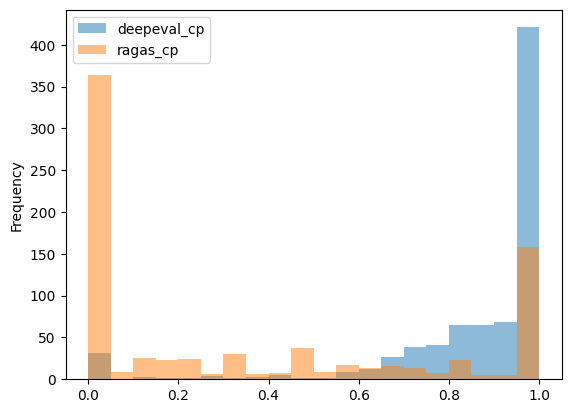

In [137]:
results.plot.hist(column=['deepeval_cp', 'ragas_cp'], bins=20, alpha=0.5)

<Axes: ylabel='Frequency'>

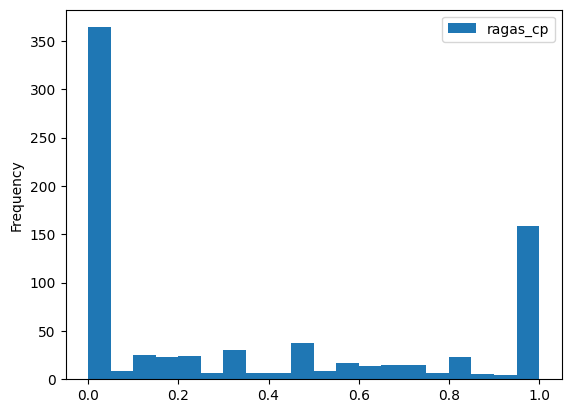

In [55]:
results.plot.hist(column=['ragas_cp'], bins=20)

In [138]:
results.to_csv("results/ragas_and_deepeval_unlabeled_results.csv", index=False)

In [67]:
unlabeled = pd.read_csv("datasets/unlabeled_dataset/unlabeled_dataset.csv", index_col=None)

In [71]:
unlabeled['Document'] = unlabeled['Document'].apply(ast.literal_eval)

In [143]:
# for my manual comparison review of results (above)
import random
for i in range(0,15):
    print(random.randint(2, 801))

109
154
400
163
741
704
126
167
724
18
379
51
514
556
586
